# CNN for Music Genre Classification

## Imports

In [1]:
# %pip install librosa

In [33]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

## GPU Availability

In [34]:
print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

x = torch.rand(1000, 1000).cuda()
y = torch.matmul(x, x)
print("Test Tensor Shape (on GPU):", y.shape)

Is CUDA available: True
GPU Name: NVIDIA A100 80GB PCIe
Test Tensor Shape (on GPU): torch.Size([1000, 1000])


## Data Preprocessing

In [4]:
os.listdir('./Data/GTZAN/genres_original')

['rock',
 'country',
 'pop',
 'metal',
 'jazz',
 'reggae',
 'classical',
 'disco',
 'hiphop',
 'blues']

### Spectrogram Creation

In [35]:
input_dataset_path = './Data/GTZAN/genres_original'
output_dataset_path = './Data/GTZAN/genres_spectrograms'
# os.makedirs(output_dataset_path, exist_ok=True)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

n_mels = 128
hop_length = 512
win_length = 1024

aspect_ratio = 2
fig_width = 8
fig_height = fig_width / aspect_ratio
dpi = 128

for genre in genres:
    genre_input_path = os.path.join(input_dataset_path, genre)
    genre_output_path = os.path.join(output_dataset_path, genre)
#     os.makedirs(genre_output_path, exist_ok=True)

    for filename in os.listdir(genre_input_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(genre_input_path, filename)
            try:
                y, sr = librosa.load(file_path, sr=None)
                S = librosa.feature.melspectrogram(
                    y=y,
                    sr=sr,
                    n_mels=n_mels,
                    hop_length=hop_length,
                    win_length=win_length
                )
                S_dB = librosa.power_to_db(S, ref=np.max)
                fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
                ax = fig.add_axes([0, 0, 1, 1])
                ax.axis('off')
                librosa.display.specshow(
                    S_dB,
                    sr=sr,
                    hop_length=hop_length,
                    cmap='gray',
                    ax=ax
                )
                output_file = os.path.join(
                    genre_output_path,
                    os.path.splitext(filename)[0] + '.png'
                )
                fig.savefig(
                    output_file,
                    bbox_inches='tight',
                    pad_inches=0
                )
                plt.close(fig)
                print(f"Saved spectrogram for {filename} in {genre} genre.")
            except Exception as e:
                print(f"Error processing file {filename} in {genre} genre: {e}")
                continue

Saved spectrogram for blues.00071.wav in blues genre.
Saved spectrogram for blues.00058.wav in blues genre.
Saved spectrogram for blues.00097.wav in blues genre.
Saved spectrogram for blues.00067.wav in blues genre.
Saved spectrogram for blues.00087.wav in blues genre.
Saved spectrogram for blues.00081.wav in blues genre.
Saved spectrogram for blues.00028.wav in blues genre.
Saved spectrogram for blues.00065.wav in blues genre.
Saved spectrogram for blues.00079.wav in blues genre.
Saved spectrogram for blues.00018.wav in blues genre.
Saved spectrogram for blues.00042.wav in blues genre.
Saved spectrogram for blues.00011.wav in blues genre.
Saved spectrogram for blues.00002.wav in blues genre.
Saved spectrogram for blues.00003.wav in blues genre.
Saved spectrogram for blues.00019.wav in blues genre.
Saved spectrogram for blues.00044.wav in blues genre.
Saved spectrogram for blues.00032.wav in blues genre.
Saved spectrogram for blues.00074.wav in blues genre.
Saved spectrogram for blues.

#### Image Verification

In [36]:
from PIL import Image

def verify_image_sizes(directory, expected_size=(1024, 512)):
    sizes = set()
    for genre in genres:
        genre_path = os.path.join(directory, genre)
        for filename in os.listdir(genre_path):
            if filename.endswith('.png'):
                file_path = os.path.join(genre_path, filename)
                with Image.open(file_path) as img:
                    sizes.add(img.size)
    if len(sizes) == 1 and sizes.pop() == expected_size:
        print(f"All images have the expected size: {expected_size}")
    else:
        print(f"Images have varying sizes: {sizes}")

verify_image_sizes(output_dataset_path)

All images have the expected size: (1024, 512)


#### Sample Visualization

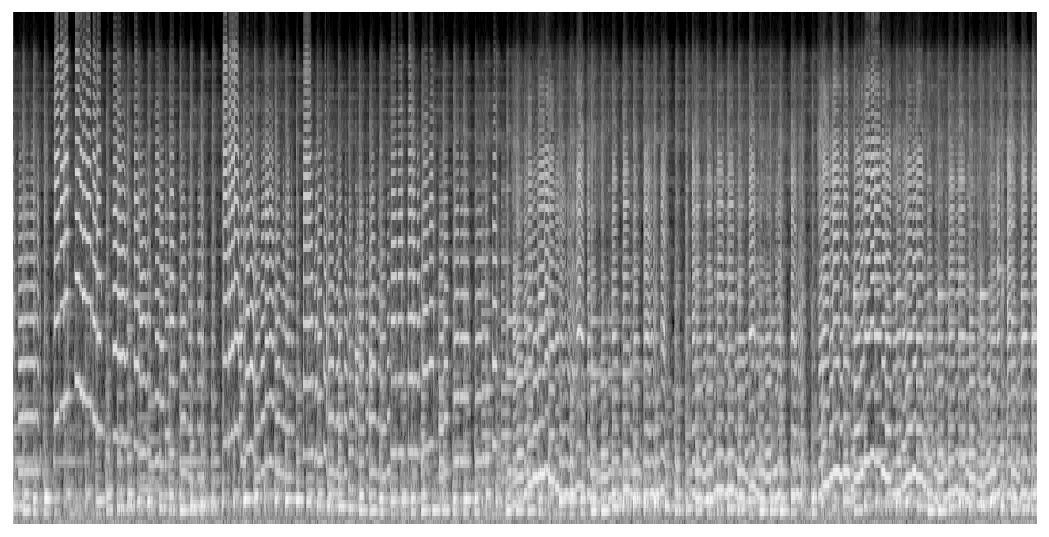

In [8]:
sample_file = './Data/GTZAN/genres_original/jazz/jazz.00053.wav'
y, sr = librosa.load(sample_file, sr=None)

n_mels = 128
hop_length = 512
win_length = 1024

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(8, 4), dpi=128)
ax.axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, cmap='gray', ax=ax)
# plt.savefig('spectrogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Data Splitting

In [37]:
output_dataset_path = './Data/GTZAN/genres_spectrograms'
train_path = './Data/GTZAN/split/train'
val_path = './Data/GTZAN/split/val'
test_path = './Data/GTZAN/split/test'

# for path in [train_path, val_path, test_path]:
#     os.makedirs(path, exist_ok=True)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for genre in genres:
    genre_path = os.path.join(output_dataset_path, genre)
    files = [os.path.join(genre_path, f) for f in os.listdir(genre_path) if f.endswith('.png')]
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    for dataset, dataset_path in zip([train_files, val_files, test_files], [train_path, val_path, test_path]):
        genre_split_path = os.path.join(dataset_path, genre)
#         os.makedirs(genre_split_path, exist_ok=True)
        for file in dataset:
            shutil.copy(file, os.path.join(genre_split_path, os.path.basename(file)))

print("Data splitting completed!")

Data splitting completed!


## CNN Architecture

In [38]:
class CNNGenreClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNGenreClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (32, 256, 512)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (64, 128, 256)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (128, 64, 128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (256, 32, 64)

        self.fc1 = nn.Linear(256 * 32 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Data Pipeline

In [39]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dir = './Data/GTZAN/split/train'
val_dir = './Data/GTZAN/split/val'
test_dir = './Data/GTZAN/split/test'

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


## Training

In [40]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = val_loss / len(val_loader)
    return avg_loss, accuracy

def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNGenreClassifier(num_classes=10).to(device)
# model = CNNGenreClassifier(num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation step
    val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/20, Train Loss: 9.3403, Val Loss: 2.6516, Val Accuracy: 10.00%
Epoch 2/20, Train Loss: 2.3869, Val Loss: 2.2321, Val Accuracy: 16.00%
Epoch 3/20, Train Loss: 2.1938, Val Loss: 2.0991, Val Accuracy: 30.67%
Epoch 4/20, Train Loss: 2.1652, Val Loss: 2.0113, Val Accuracy: 34.00%
Epoch 5/20, Train Loss: 2.1200, Val Loss: 1.9671, Val Accuracy: 40.00%
Epoch 6/20, Train Loss: 2.0636, Val Loss: 1.9871, Val Accuracy: 35.33%
Epoch 7/20, Train Loss: 2.0060, Val Loss: 1.9295, Val Accuracy: 38.00%
Epoch 8/20, Train Loss: 1.9925, Val Loss: 1.8385, Val Accuracy: 40.67%
Epoch 9/20, Train Loss: 1.9679, Val Loss: 1.9104, Val Accuracy: 40.00%
Epoch 10/20, Train Loss: 1.9712, Val Loss: 1.8001, Val Accuracy: 43.33%
Epoch 11/20, Train Loss: 1.8983, Val Loss: 1.7212, Val Accuracy: 45.33%
Epoch 12/20, Train Loss: 1.8850, Val Loss: 1.8527, Val Accuracy: 34.67%
Epoch 13/20, Train Loss: 1.8823, Val Loss: 1.8060, Val Accuracy: 38.67%
Epoch 14/20, Train Loss: 1.8598, Val Loss: 1.7745, Val Accuracy: 40.00%
E

In [43]:
# Test the model on the test dataset
test_accuracy = test_model(model, test_loader, device)

Test Accuracy: 46.67%


In [44]:
import os
import pickle
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define hyperparameter grid
param_grid = {
    'batch_size': [16, 32],
    'learning_rate': [0.1, 0.01, 0.001],
    'dropout': [0.3, 0.5],
    'optimizer': ['adam', 'sgd']
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

# Checkpoint file path
checkpoint_file = "grid_search_checkpoint.pkl"

# Load previous checkpoint if it exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
    results = checkpoint['results']
    best_params = checkpoint['best_params']
    best_accuracy = checkpoint['best_accuracy']
    start_index = checkpoint['last_index'] + 1
    print(f"Resuming from combination {start_index}/{len(param_combinations)}")
else:
    results = []
    best_params = None
    best_accuracy = 0.0
    start_index = 0
    print("Starting new grid search")

# Training function
def train_model(train_loader, val_loader, params):
    batch_size, lr, dropout, optimizer_name = params

    model = CNNGenreClassifier(num_classes=10)
    model.dropout = nn.Dropout(dropout)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == 'adam' else \
                optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
    return val_loss, val_accuracy

# Perform grid search
for i, params in enumerate(param_combinations[start_index:], start=start_index):
    print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
    
    batch_size = params[0]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    val_loss, val_accuracy = train_model(train_loader, val_loader, params)
    results.append({'params': params, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

    # Save progress to checkpoint
    checkpoint = {
        'results': results,
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'last_index': i
    }
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"Intermediate Best: Params: {best_params}, Best Validation Accuracy: {best_accuracy:.2f}%")

# Final results
print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_accuracy:.2f}%")

sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
for result in sorted_results[:5]:
    print(f"Params: {result['params']}, Val Loss: {result['val_loss']:.4f}, Val Accuracy: {result['val_accuracy']:.2f}%")

Resuming from combination 24/24
Best Parameters: (32, 0.001, 0.3, 'sgd'), Best Validation Accuracy: 76.00%
Params: (32, 0.001, 0.3, 'sgd'), Val Loss: 1.0705, Val Accuracy: 76.00%
Params: (16, 0.001, 0.3, 'sgd'), Val Loss: 1.0769, Val Accuracy: 70.00%
Params: (32, 0.001, 0.5, 'sgd'), Val Loss: 1.2095, Val Accuracy: 63.33%
Params: (32, 0.001, 0.3, 'adam'), Val Loss: 1.2411, Val Accuracy: 61.33%
Params: (16, 0.001, 0.5, 'sgd'), Val Loss: 1.4309, Val Accuracy: 50.67%


In [45]:
import os
import pickle
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

dropout = 0.3
param_grid = {
    'batch_size': [32],
    'learning_rate': [0.0008, 0.00085, 0.0009, 0.00095],
    'momentum': [0.9, 0.95],
    'weight_decay': [1e-4, 1e-5]
}

param_combinations = list(itertools.product(*param_grid.values()))

# Checkpoint file path
checkpoint_file = "grid_search_checkpoint_3.pkl"

# Load previous checkpoint if it exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
    results = checkpoint['results']
    best_params = checkpoint['best_params']
    best_accuracy = checkpoint['best_accuracy']
    start_index = checkpoint['last_index'] + 1
    print(f"Resuming from combination {start_index}/{len(param_combinations)}")
else:
    results = []
    best_params = None
    best_accuracy = 0.0
    start_index = 0
    print("Starting new grid search")

# Training function

def train_model_sgd(train_loader, val_loader, params):
    learning_rate, momentum, weight_decay = params

    model = CNNGenreClassifier(num_classes=10)
    model.dropout = nn.Dropout(dropout)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)

    return val_loss, val_accuracy


# Perform grid search
for i, params in enumerate(param_combinations[start_index:], start=start_index):
    print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
    
    batch_size, learning_rate, momentum, weight_decay = params

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Pass the additional momentum and weight_decay parameters
    val_loss, val_accuracy = train_model_sgd(train_loader, val_loader, (learning_rate, momentum, weight_decay))
    results.append({'params': params, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

    # Save progress to checkpoint
    checkpoint = {
        'results': results,
        'best_params': best_params,
        'best_accuracy': best_accuracy,
        'last_index': i
    }
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"Intermediate Best: Params: {best_params}, Best Validation Accuracy: {best_accuracy:.2f}%")
    
print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_accuracy:.2f}%")

sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
for result in sorted_results[:5]:
    print(f"Params: {result['params']}, Val Loss: {result['val_loss']:.4f}, Val Accuracy: {result['val_accuracy']:.2f}%")

Starting new grid search
Testing combination 1/16: (32, 0.0008, 0.9, 0.0001)
Intermediate Best: Params: (32, 0.0008, 0.9, 0.0001), Best Validation Accuracy: 66.00%
Testing combination 2/16: (32, 0.0008, 0.9, 1e-05)
Intermediate Best: Params: (32, 0.0008, 0.9, 0.0001), Best Validation Accuracy: 66.00%
Testing combination 3/16: (32, 0.0008, 0.95, 0.0001)
Intermediate Best: Params: (32, 0.0008, 0.95, 0.0001), Best Validation Accuracy: 67.33%
Testing combination 4/16: (32, 0.0008, 0.95, 1e-05)
Intermediate Best: Params: (32, 0.0008, 0.95, 0.0001), Best Validation Accuracy: 67.33%
Testing combination 5/16: (32, 0.00085, 0.9, 0.0001)
Intermediate Best: Params: (32, 0.0008, 0.95, 0.0001), Best Validation Accuracy: 67.33%
Testing combination 6/16: (32, 0.00085, 0.9, 1e-05)
Intermediate Best: Params: (32, 0.0008, 0.95, 0.0001), Best Validation Accuracy: 67.33%
Testing combination 7/16: (32, 0.00085, 0.95, 0.0001)
Intermediate Best: Params: (32, 0.0008, 0.95, 0.0001), Best Validation Accuracy: 6